In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

In [7]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [8]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
train.label.unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6])

In [10]:
y_train = train['label']
X_train = train.drop('label', axis=1)
del train #free some space

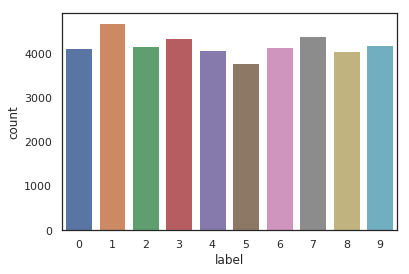

In [11]:
sns.countplot(y_train)

In [25]:
print(X_train.isnull().any().describe())
print(test.isnull().any().describe())

count       784
unique        1
top       False
freq        784
dtype: object
count       784
unique        1
top       False
freq        784
dtype: object


In [26]:
X_train /= 255.0
test /= 255.0

In [28]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1,28,28,1)

In [27]:
y_train = to_categorical(y_train, num_classes = 10)

In [29]:
random_seed = 2

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=random_seed)

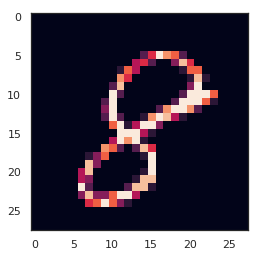

In [41]:
plt.imshow(X_train[0][:,:,0])

In [45]:
model = Sequential()

model.add(Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [46]:
optimizer = RMSprop(epsilon=1e-08)

In [47]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

In [48]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, verbose=1, min_lr=0.00001)

In [53]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [54]:
# With data augmentation to prevent overfitting (accuracy 0.99286)
datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)
datagen.fit(X_train)

In [56]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_val, y_val), verbose=1, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=[learning_rate_reduction])

Epoch 1/30
439/439 [==============================] - 13s 31ms/step - loss: 0.0892 - acc: 0.9734 - val_loss: 0.0345 - val_acc: 0.9893
Epoch 2/30
439/439 [==============================] - 15s 34ms/step - loss: 0.0775 - acc: 0.9775 - val_loss: 0.0322 - val_acc: 0.9910
Epoch 3/30
439/439 [==============================] - 15s 33ms/step - loss: 0.0693 - acc: 0.9796 - val_loss: 0.0319 - val_acc: 0.9912
Epoch 4/30
439/439 [==============================] - 14s 32ms/step - loss: 0.0669 - acc: 0.9805 - val_loss: 0.0248 - val_acc: 0.9929
Epoch 5/30
439/439 [==============================] - 14s 32ms/step - loss: 0.0611 - acc: 0.9820 - val_loss: 0.0277 - val_acc: 0.9926
Epoch 6/30
439/439 [==============================] - 15s 33ms/step - loss: 0.0625 - acc: 0.9819 - val_loss: 0.0214 - val_acc: 0.9940
Epoch 7/30
439/439 [==============================] - 14s 32ms/step - loss: 0.0621 - acc: 0.9821 - val_loss: 0.0308 - val_acc: 0.9919
Epoch 8/30
439/439 [==============================] - 14s 33ms

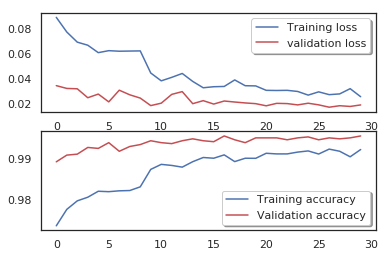

In [57]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

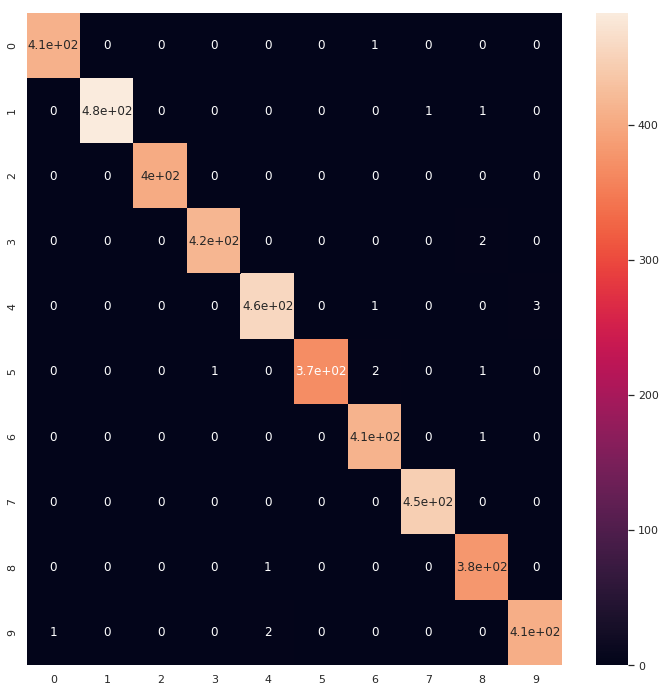

In [64]:
# Predict the values from the validation dataset
y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1)
# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plt.figure(figsize=(12,12))
sns.heatmap(confusion_mtx, annot=True) 

In [65]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (y_pred_classes - y_true != 0)
y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
X_val_errors = X_val[errors]

In [66]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

<Figure size 864x864 with 0 Axes>

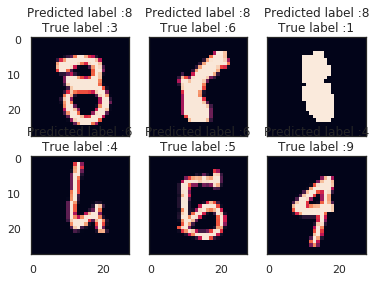

In [71]:
# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, y_pred_classes_errors, y_true_errors)

Introduction to CNN Keras           
https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook